<a href="https://colab.research.google.com/github/prachiti98/GestureRecognition/blob/master/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 109.2MB 84kB/s 
     |████████████████████████████████| 3.2MB 24.3MB/s 
     |████████████████████████████████| 491kB 45.9MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


2.2.0-rc2


In [0]:
import cv2
import numpy as np
import os
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd


x = []
y = []

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix





# New Section

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
imagepaths = []
for root,dirs, files in os.walk("/content/drive/My Drive/leapGestRecog",topdown = False): 
  for name in files:
    path = os.path.join(root,name)
    if path.endswith("png"):
      imagepaths.append(path)

print(len(imagepaths))


20010


In [0]:
def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


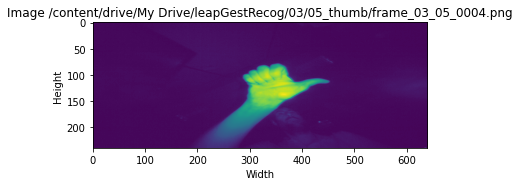

In [27]:
plot_image(imagepaths[0])

In [28]:
X = [] # Image data
y = [] # Labels


all_imagepaths = imagepaths
imagepaths = imagepaths[:10000]


#Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  #Processing label in image path
  category = path.split("/")[6]
  label = (category.split("_")[0][1]) # We need to convert 05_down to 5, or else it crashes
  y.append(label)



# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  10000
Labels loaded:  10000
5 /content/drive/My Drive/leapGestRecog/03/05_thumb/frame_03_05_0004.png


Test 1: Training of 500 images take 2 mins.
Test 2: Training of 10,000 images takes 100 mins.
Test 3: Training of 20,000 images takes mins.

In [0]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [0]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [0]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [0]:
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Train on 7000 samples, validate on 3000 samples
Epoch 1/5


Test 1: 38% accurate with a training on 50 images

In [0]:
model.save('handrecognition_model.h5')

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

150/150 [==============================] - 3s 19ms/step
Test accuracy: 38.00%


In [0]:
predictions = model.predict(X_test)
print(predictions[0])

In [0]:
print(y_test)
np.argmax(predictions[0]), y_test[0]

In [0]:
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
      boolean_variable = "True"
    else:
      color = 'red'
      boolean_variable = "False"

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],100*np.max(prediction),class_names[int(true_label)]),color=color)
    plt.show()


In [0]:
validate_9_images(predictions, y_test, X_test)

Red means prediction wrong (Since trained on a small data, all are red)
Blue means prediction right

In [0]:
y_pred = np.argmax(predictions, axis=1)

In [0]:
Confusion matrix left to be made